In [14]:
import pandas
import numpy as np

In [16]:
traffic_data = pandas.read_csv('/Users/adrianchoi/Desktop/760/ncp-time-series/data/Metro_Interstate_Traffic_Volume.csv')

In [17]:
pandas.DataFrame.info(traffic_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [18]:
pandas.DataFrame.describe(traffic_data)

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [19]:
import matplotlib.pyplot as plt
import datetime
import scipy.stats

In [20]:
holiday = (traffic_data["holiday"].values == None).astype(np.float32)
temp = traffic_data["temp"].values.astype(np.float32)
temp -= np.mean(temp) #normalize temp by annual mean
rain = traffic_data["rain_1h"].values.astype(np.float32)
snow = traffic_data["snow_1h"].values.astype(np.float32)
clouds = traffic_data["clouds_all"].values.astype(np.float32)
date_time = traffic_data["date_time"].values
    #2012-10-02 13:00:00
date_time = [datetime.datetime.strptime(d,"%Y-%m-%d %H:%M:%S") for d in date_time]
weekday = np.array([d.weekday() for d in date_time]).astype(np.float32)
noon = np.array([d.hour for d in date_time]).astype(np.float32)
noon = np.sin(noon*np.pi/24)

features = np.stack([holiday,temp,rain,snow,clouds,weekday,noon],axis=-1)

traffic_volume = traffic_data["traffic_volume"].values.astype(np.float32)
traffic_volume -= np.mean(traffic_volume) #normalize
traffic_volume /= np.std(traffic_volume) #normalize

<AxesSubplot:ylabel='Density'>

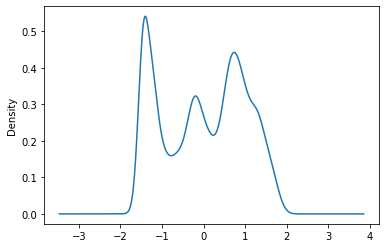

In [21]:
pandas.Series(traffic_volume).plot.kde()

In [22]:
#np.savetxt("preprocessed_traffic_data.csv", features, delimiter=",")

In [24]:
preprocessed_traffic_data = pandas.read_csv('/Users/adrianchoi/Desktop/760/ncp-time-series/preprocessed_traffic_data.csv')

In [25]:
pandas.DataFrame.describe(preprocessed_traffic_data)

,holiday,temp,rain,snow,clouds,weeday,noon
count,48204.0,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,0.0,-0.002409,0.334240,0.000222,49.362231,2.984980,0.633094
std,0.0,13.337713,44.783215,0.008168,39.015750,2.005941,0.309576
min,0.0,-281.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,-9.050000,0.000000,0.000000,1.000000,1.000000,0.383000
50%,0.0,1.240000,0.000000,0.000000,64.000000,3.000000,0.707000
75%,0.0,10.600000,0.000000,0.000000,90.000000,5.000000,0.924000
max,0.0,28.900000,9830.000000,0.510000,100.000000,6.000000,1.000000


In [26]:
def cut_in_sequences(x,y,seq_len,inc=1):

    sequences_x = []
    sequences_y = []

    for s in range(0,x.shape[0] - seq_len,inc):
        start = s
        end = start+seq_len
        sequences_x.append(x[start:end])
        sequences_y.append(y[start:end])

    return np.stack(sequences_x,axis=1),np.stack(sequences_y,axis=1)

In [27]:
train_x,train_y = cut_in_sequences(features,traffic_volume,32,inc=4)
train_x = np.stack(train_x,axis=1)
train_y = np.stack(train_y,axis=1)

total_seqs = train_x.shape[1]
print("Total number of training sequences: {}".format(total_seqs))
permutation = np.random.RandomState(23489).permutation(total_seqs)
valid_size = int(0.1*total_seqs)
test_size = int(0.15*total_seqs)
valid_x = train_x[:,permutation[:valid_size]]
valid_y = train_y[:,permutation[:valid_size]]
test_x = train_x[:,permutation[valid_size:valid_size+test_size]]
test_y = train_y[:,permutation[valid_size:valid_size+test_size]]
train_x = train_x[:,permutation[valid_size+test_size:]]
train_y = train_y[:,permutation[valid_size+test_size:]]


Total number of training sequences: 32


In [34]:
train_x,train_y = cut_in_sequences(features,traffic_volume,32,inc=4)
train_x = np.stack(train_x,axis=1)
train_y = np.stack(train_y,axis=1)


In [17]:
import numpy as np
import os
from tensorflow import keras
from kerasncp import wirings
from kerasncp.tf import LTCCell
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
import tensorflow as tf

In [104]:
data_x = train_x
data_y = train_y
print("data_y.shape: ", str(data_y.shape))

arch = kncp.wirings.Random(32, 1, sparsity_level=0.5)  # 32 units, 1 motor neuron
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))



#traffic_ncp_history.evaluate(x=data_x, y=data_y)

#model.save("test.h5")

#restored_model = tf.keras.models.load_model("test.h5")

#restored_model.evaluate(x=valid_x, y=valid_y)

data_y.shape:  (12043, 25)
Epoch 1/20
753/753 [==============================] - 84s 101ms/step - loss: 0.3651 - val_loss: 0.2177
Epoch 2/20
753/753 [==============================] - 91s 120ms/step - loss: 0.1673 - val_loss: 0.1915
Epoch 3/20
753/753 [==============================] - 75s 100ms/step - loss: 0.1525 - val_loss: 0.1897
Epoch 4/20
753/753 [==============================] - 76s 101ms/step - loss: 0.1349 - val_loss: 0.1994
Epoch 5/20
753/753 [==============================] - 76s 101ms/step - loss: 0.1281 - val_loss: 0.1987
Epoch 6/20
753/753 [==============================] - 80s 107ms/step - loss: 0.1235 - val_loss: 0.1940
Epoch 7/20
753/753 [==============================] - 82s 108ms/step - loss: 0.1199 - val_loss: 0.1920
Epoch 8/20
753/753 [==============================] - 79s 104ms/step - loss: 0.1154 - val_loss: 0.1911
Epoch 9/20
753/753 [==============================] - 83s 110ms/step - loss: 0.1219 - val_loss: 0.1888
Epoch 10/20
753/753 [=========================

AttributeError: 'History' object has no attribute 'evaluate'

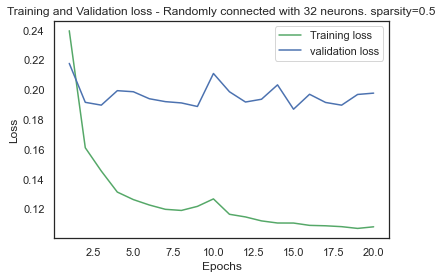

In [111]:
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss - Randomly connected with 32 neurons. sparsity=0.5')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [117]:
arch = kncp.wirings.Random(19, 1, sparsity_level=0.5)  # 19 units, 1 motor neuron
rnn_cell = LTCCell(arch)


model_rand19 = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model_rand19.compile(
    optimizer=tf.keras.optimizers.Adam(0.01), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model_rand19.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))

Epoch 1/20
753/753 [==============================] - 58s 67ms/step - loss: 0.4443 - val_loss: 0.2313
Epoch 2/20
753/753 [==============================] - 50s 66ms/step - loss: 0.1907 - val_loss: 0.1898
Epoch 3/20
753/753 [==============================] - 50s 66ms/step - loss: 0.1604 - val_loss: 0.1801
Epoch 4/20
753/753 [==============================] - 51s 68ms/step - loss: 0.1527 - val_loss: 0.1759
Epoch 5/20
753/753 [==============================] - 56s 75ms/step - loss: 0.1462 - val_loss: 0.1840
Epoch 6/20
753/753 [==============================] - 56s 74ms/step - loss: 0.1407 - val_loss: 0.1956
Epoch 7/20
753/753 [==============================] - 52s 69ms/step - loss: 0.1439 - val_loss: 0.1828
Epoch 8/20
753/753 [==============================] - 54s 72ms/step - loss: 0.1373 - val_loss: 0.1915
Epoch 9/20
753/753 [==============================] - 55s 73ms/step - loss: 0.1341 - val_loss: 0.2007
Epoch 10/20
753/753 [==============================] - 51s 68ms/step - loss: 0.134

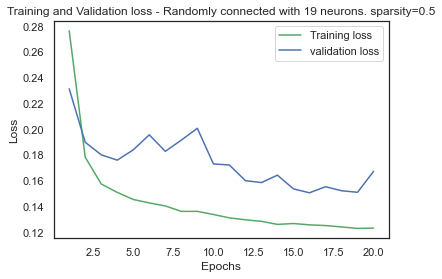

In [118]:
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss - Randomly connected with 19 neurons. sparsity=0.5')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [127]:
arch = kncp.wirings.Random(19, 1, sparsity_level=0.5)  # 19 units, 1 motor neuron
rnn_cell = LTCCell(arch)


model_rand19_200 = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model_rand19_200.compile(
    optimizer=tf.keras.optimizers.Adam(0.01), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model_rand19_200.fit(x=data_x, y=data_y, batch_size=16, epochs=200, validation_data=(valid_x,valid_y))

Epoch 1/200
753/753 [==============================] - 55s 64ms/step - loss: 0.4587 - val_loss: 0.2055
Epoch 2/200
753/753 [==============================] - 51s 67ms/step - loss: 0.1922 - val_loss: 0.1989
Epoch 3/200
753/753 [==============================] - 49s 65ms/step - loss: 0.1758 - val_loss: 0.1886
Epoch 4/200
753/753 [==============================] - 48s 64ms/step - loss: 0.1663 - val_loss: 0.1913
Epoch 5/200
753/753 [==============================] - 50s 66ms/step - loss: 0.1638 - val_loss: 0.1941
Epoch 6/200
753/753 [==============================] - 49s 65ms/step - loss: 0.1600 - val_loss: 0.1892
Epoch 7/200
753/753 [==============================] - 49s 65ms/step - loss: 0.1569 - val_loss: 0.1778
Epoch 8/200
753/753 [==============================] - 51s 68ms/step - loss: 0.1559 - val_loss: 0.1818
Epoch 9/200
753/753 [==============================] - 52s 68ms/step - loss: 0.1550 - val_loss: 0.1773
Epoch 10/200
753/753 [==============================] - 53s 70ms/step - l

KeyboardInterrupt: 

In [ ]:
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,201)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss - Randomly connected with 19 neurons. sparsity=0.5')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [130]:
arch = kncp.wirings.Random(19, 1, sparsity_level=0.3)  # 19 units, 1 motor neuron
rnn_cell = LTCCell(arch)


model_rand19_200_30spar = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model_rand19_200_30spar.compile(
    optimizer=tf.keras.optimizers.Adam(0.01), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_19neuron_30spar = model_rand19_200_30spar.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))

Epoch 1/20
753/753 [==============================] - 56s 65ms/step - loss: 0.3403 - val_loss: 0.1908
Epoch 2/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1692 - val_loss: 0.1921
Epoch 3/20
753/753 [==============================] - 50s 66ms/step - loss: 0.1601 - val_loss: 0.1969
Epoch 4/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1478 - val_loss: 0.1940
Epoch 5/20
753/753 [==============================] - 51s 68ms/step - loss: 0.1415 - val_loss: 0.1822
Epoch 6/20
753/753 [==============================] - 51s 68ms/step - loss: 0.1317 - val_loss: 0.1838
Epoch 7/20
753/753 [==============================] - 49s 66ms/step - loss: 0.1339 - val_loss: 0.1863
Epoch 8/20
753/753 [==============================] - 49s 66ms/step - loss: 0.1300 - val_loss: 0.1686
Epoch 9/20
753/753 [==============================] - 50s 67ms/step - loss: 0.1274 - val_loss: 0.1789
Epoch 10/20
753/753 [==============================] - 49s 66ms/step - loss: 0.124

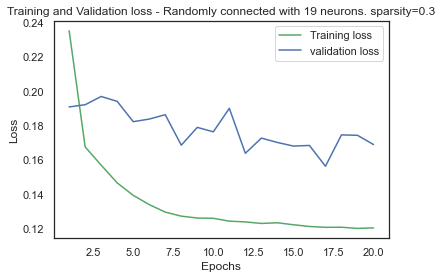

In [132]:
loss_train = traffic_ncp_19neuron_30spar.history['loss']
loss_val = traffic_ncp_19neuron_30spar.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss - Randomly connected with 19 neurons. sparsity=0.3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [133]:
arch = kncp.wirings.Random(16, 1, sparsity_level=0.5)  # 16 units, 1 motor neuron
rnn_cell = LTCCell(arch)


model_rand16 = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model_rand16.compile(
    optimizer=tf.keras.optimizers.Adam(0.01), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_16 = model_rand16.fit(x=data_x, y=data_y, batch_size=16, epochs=100, validation_data=(valid_x,valid_y))

Epoch 1/100
753/753 [==============================] - 54s 61ms/step - loss: 0.3857 - val_loss: 0.1931
Epoch 2/100
753/753 [==============================] - 47s 63ms/step - loss: 0.1910 - val_loss: 0.1838
Epoch 3/100
753/753 [==============================] - 48s 64ms/step - loss: 0.1777 - val_loss: 0.1818
Epoch 4/100
753/753 [==============================] - 48s 64ms/step - loss: 0.1709 - val_loss: 0.1810
Epoch 5/100
753/753 [==============================] - 48s 63ms/step - loss: 0.1632 - val_loss: 0.1803
Epoch 6/100
753/753 [==============================] - 47s 63ms/step - loss: 0.1627 - val_loss: 0.1843
Epoch 7/100
753/753 [==============================] - 47s 63ms/step - loss: 0.1569 - val_loss: 0.1861
Epoch 8/100
753/753 [==============================] - 47s 63ms/step - loss: 0.1573 - val_loss: 0.1833
Epoch 9/100
753/753 [==============================] - 48s 64ms/step - loss: 0.1531 - val_loss: 0.1739
Epoch 10/100
753/753 [==============================] - 47s 63ms/step - l

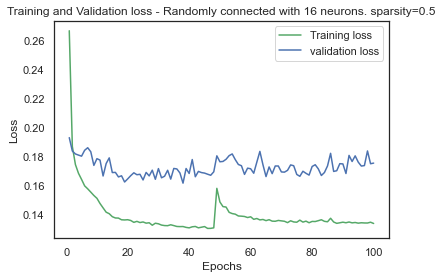

In [134]:
loss_train = traffic_ncp_16.history['loss']
loss_val = traffic_ncp_16.history['val_loss']
epochs = range(1,101)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss - Randomly connected with 16 neurons. sparsity=0.5')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [141]:
arch = kncp.wirings.Random(16, 1, sparsity_level=0.4)  # 13 units, 1 motor neuron
rnn_cell = LTCCell(arch)


model_rand16_40 = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model_rand16_40.compile(
    optimizer=tf.keras.optimizers.Adam(0.01), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_16_40 = model_rand16_40.fit(x=data_x, y=data_y, batch_size=16, epochs=50, validation_data=(valid_x,valid_y))

Epoch 1/50
753/753 [==============================] - 61s 70ms/step - loss: 0.4055 - val_loss: 0.1959
Epoch 2/50
753/753 [==============================] - 49s 65ms/step - loss: 0.1882 - val_loss: 0.1878
Epoch 3/50
753/753 [==============================] - 47s 63ms/step - loss: 0.1789 - val_loss: 0.1898
Epoch 4/50
753/753 [==============================] - 47s 63ms/step - loss: 0.1668 - val_loss: 0.1854
Epoch 5/50
753/753 [==============================] - 47s 63ms/step - loss: 0.1617 - val_loss: 0.1842
Epoch 6/50
753/753 [==============================] - 48s 63ms/step - loss: 0.1507 - val_loss: 0.1794
Epoch 7/50
753/753 [==============================] - 47s 62ms/step - loss: 0.1490 - val_loss: 0.1826
Epoch 8/50
753/753 [==============================] - 47s 62ms/step - loss: 0.1451 - val_loss: 0.1962
Epoch 9/50
753/753 [==============================] - 46s 61ms/step - loss: 0.1461 - val_loss: 0.1789
Epoch 10/50
753/753 [==============================] - 46s 62ms/step - loss: 0.145

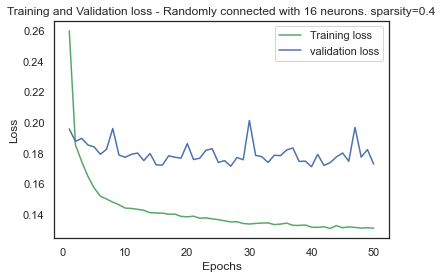

In [142]:
loss_train = traffic_ncp_16_40.history['loss']
loss_val = traffic_ncp_16_40.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss - Randomly connected with 16 neurons. sparsity=0.4')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [143]:
arch = kncp.wirings.Random(17, 1, sparsity_level=0.5)  # 17 units, 1 motor neuron
rnn_cell = LTCCell(arch)


model_rand17_50 = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model_rand17_50.compile(
    optimizer=tf.keras.optimizers.Adam(0.01), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_17_50 = model_rand17_50.fit(x=data_x, y=data_y, batch_size=16, epochs=50, validation_data=(valid_x,valid_y))

Epoch 1/50
308/753 [===========>..................] - ETA: 27s - loss: 0.5723

KeyboardInterrupt: 

In [ ]:
loss_train = traffic_ncp_17_50.history['loss']
loss_val = traffic_ncp_17_50.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss - Randomly connected with 16 neurons. sparsity=0.4')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
arch = kncp.wirings.Random(19, 1, sparsity_level=0.4)  # 19 units, 1 motor neuron
rnn_cell = LTCCell(arch)


model_rand19_40 = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model_rand19_40.compile(
    optimizer=tf.keras.optimizers.Adam(0.01), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_19_40 = model_rand19_40.fit(x=data_x, y=data_y, batch_size=16, epochs=50, validation_data=(valid_x,valid_y))

In [ ]:
loss_train = traffic_ncp_19_40.history['loss']
loss_val = traffic_ncp_19_40.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss - Randomly connected with 16 neurons. sparsity=0.4')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
arch = kncp.wirings.Random(16, 1, sparsity_level=0.7)  # 16 units, 1 motor neuron
rnn_cell = LTCCell(arch)


model_rand16_70 = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model_rand16_70.compile(
    optimizer=tf.keras.optimizers.Adam(0.01), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_16_70 = model_rand16_70.fit(x=data_x, y=data_y, batch_size=16, epochs=50, validation_data=(valid_x,valid_y))

In [ ]:
loss_train = traffic_ncp_16_70.history['loss']
loss_val = traffic_ncp_16_70.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss - Randomly connected with 16 neurons. sparsity=0.5, adam.005')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
arch = kncp.wirings.Random(19, 1, sparsity_level=0.4)  # 16 units, 1 motor neuron
rnn_cell = LTCCell(arch)


model_rand19_40 = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model_rand19_40.compile(
    optimizer=tf.keras.optimizers.Adam(0.005), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_19_40 = model_rand19_40.fit(x=data_x, y=data_y, batch_size=16, epochs=50, validation_data=(valid_x,valid_y))

In [ ]:
loss_train = traffic_ncp_19_40.history['loss']
loss_val = traffic_ncp_19_40.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss - 10_8_1_1_1_1_1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [170]:
arch = kncp.wirings.Random(19, 1, sparsity_level=0.5)  # 19 units, 1 motor neuron
rnn_cell = LTCCell(arch)


model_rand19 = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model_rand19.compile(
    optimizer=tf.keras.optimizers.Adam(0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=tf.keras.metrics.MeanSquaredError())

traffic_ncp_history = model_rand19.fit(x=data_x, y=data_y, batch_size=20, epochs=20, validation_data=(valid_x,valid_y))

Epoch 1/20
603/603 [==============================] - 57s 80ms/step - loss: 0.4438 - mean_squared_error: 0.4438 - val_loss: 0.2201 - val_mean_squared_error: 0.2201
Epoch 2/20
603/603 [==============================] - 45s 75ms/step - loss: 0.1885 - mean_squared_error: 0.1885 - val_loss: 0.1984 - val_mean_squared_error: 0.1984
Epoch 3/20
603/603 [==============================] - 44s 74ms/step - loss: 0.1723 - mean_squared_error: 0.1723 - val_loss: 0.1930 - val_mean_squared_error: 0.1930
Epoch 4/20
603/603 [==============================] - 45s 74ms/step - loss: 0.1631 - mean_squared_error: 0.1631 - val_loss: 0.2024 - val_mean_squared_error: 0.2024
Epoch 5/20
603/603 [==============================] - 45s 75ms/step - loss: 0.1579 - mean_squared_error: 0.1579 - val_loss: 0.1970 - val_mean_squared_error: 0.1970
Epoch 6/20
603/603 [==============================] - 49s 81ms/step - loss: 0.1550 - mean_squared_error: 0.1550 - val_loss: 0.1891 - val_mean_squared_error: 0.1891
Epoch 7/20
603/6

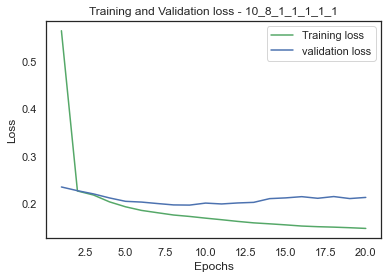

In [169]:
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss - 10_8_1_1_1_1_1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [147]:
arch = kncp.wirings.Random(6, 1, sparsity_level=0.5)  # 19 units, 1 motor neuron
rnn_cell = LTCCell(arch)


model_rand19 = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model_rand19.compile(
    optimizer=tf.keras.optimizers.Adam(0.005), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model_rand19.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))

Epoch 1/20
753/753 [==============================] - 53s 60ms/step - loss: 0.5436 - val_loss: 0.3366
Epoch 2/20
753/753 [==============================] - 44s 59ms/step - loss: 0.3370 - val_loss: 0.3307
Epoch 3/20
753/753 [==============================] - 44s 59ms/step - loss: 0.2790 - val_loss: 0.2360
Epoch 4/20
753/753 [==============================] - 44s 59ms/step - loss: 0.2345 - val_loss: 0.2307
Epoch 5/20
753/753 [==============================] - 44s 58ms/step - loss: 0.2216 - val_loss: 0.2073
Epoch 6/20
753/753 [==============================] - 44s 58ms/step - loss: 0.2025 - val_loss: 0.2002
Epoch 7/20
753/753 [==============================] - 44s 59ms/step - loss: 0.1988 - val_loss: 0.2039
Epoch 8/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1936 - val_loss: 0.2039
Epoch 9/20
753/753 [==============================] - 47s 62ms/step - loss: 0.1935 - val_loss: 0.1985
Epoch 10/20
753/753 [==============================] - 44s 59ms/step - loss: 0.192

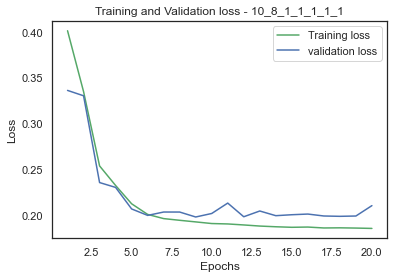

In [148]:
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss - 10_8_1_1_1_1_1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [179]:
arch = kncp.wirings.Random(8, 1, sparsity_level=0.6)  # 19 units, 1 motor neuron
rnn_cell = LTCCell(arch)


model_rand19 = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model_rand19.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model_rand19.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))

Epoch 1/20
753/753 [==============================] - 54s 61ms/step - loss: 0.4726 - val_loss: 0.2202
Epoch 2/20
753/753 [==============================] - 46s 61ms/step - loss: 0.2087 - val_loss: 0.2061
Epoch 3/20
753/753 [==============================] - 53s 71ms/step - loss: 0.2000 - val_loss: 0.2028
Epoch 4/20
753/753 [==============================] - 46s 62ms/step - loss: 0.1967 - val_loss: 0.2079
Epoch 5/20
753/753 [==============================] - 48s 63ms/step - loss: 0.1885 - val_loss: 0.1961
Epoch 6/20
753/753 [==============================] - 47s 63ms/step - loss: 0.1938 - val_loss: 0.1910
Epoch 7/20
753/753 [==============================] - 49s 65ms/step - loss: 0.1888 - val_loss: 0.1925
Epoch 8/20
753/753 [==============================] - 51s 68ms/step - loss: 0.1883 - val_loss: 0.1890
Epoch 9/20
753/753 [==============================] - 54s 71ms/step - loss: 0.1900 - val_loss: 0.1886
Epoch 10/20
753/753 [==============================] - 51s 68ms/step - loss: 0.186

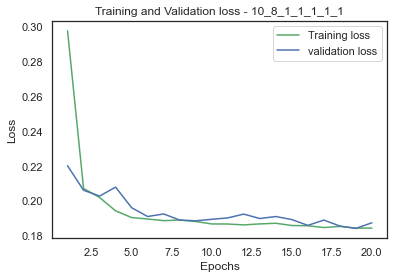

In [180]:
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss - 10_8_1_1_1_1_1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [181]:
print("Evaluate on test data")
results = model_rand19.evaluate(test_x, test_y, batch_size=18)
print("test loss, test acc:", results)

Evaluate on test data
670/670 [==============================] - 2s 2ms/step - loss: 0.1935
test loss, test acc: 0.1934884488582611


Epoch 1/20
753/753 [==============================] - 62s 71ms/step - loss: 1.0245 - val_loss: 0.9572
Epoch 2/20
753/753 [==============================] - 49s 65ms/step - loss: 0.9492 - val_loss: 0.9501
Epoch 3/20
753/753 [==============================] - 50s 67ms/step - loss: 0.9501 - val_loss: 0.9467
Epoch 4/20
753/753 [==============================] - 50s 67ms/step - loss: 0.9507 - val_loss: 0.9480
Epoch 5/20
753/753 [==============================] - 55s 73ms/step - loss: 0.9475 - val_loss: 0.9483
Epoch 6/20
753/753 [==============================] - 52s 69ms/step - loss: 0.9433 - val_loss: 0.9463
Epoch 7/20
753/753 [==============================] - 53s 70ms/step - loss: 0.9452 - val_loss: 0.9462
Epoch 8/20
753/753 [==============================] - 53s 71ms/step - loss: 0.9482 - val_loss: 0.9482
Epoch 9/20
753/753 [==============================] - 53s 70ms/step - loss: 0.9476 - val_loss: 0.9484
Epoch 10/20
753/753 [==============================] - 50s 67ms/step - loss: 0.949

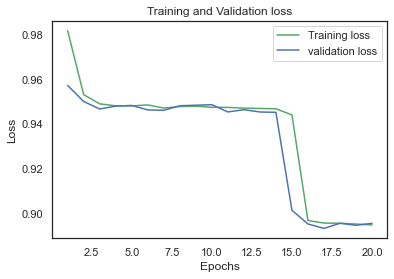

Evaluate on test data
670/670 [==============================] - 2s 2ms/step - loss: 0.8946
test loss, test acc: 0.8946308493614197


In [230]:
#3 neurons, 0.3 sparsity
arch = kncp.wirings.Random(3, 1, sparsity_level=0.3)
rnn_cell = LTCCell(arch)


model_rand19 = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model_rand19.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model_rand19.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model_rand19.evaluate(test_x, test_y, batch_size=18)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 64s 68ms/step - loss: 0.5020 - val_loss: 0.2388
Epoch 2/20
753/753 [==============================] - 45s 59ms/step - loss: 0.2306 - val_loss: 0.2080
Epoch 3/20
753/753 [==============================] - 45s 59ms/step - loss: 0.2148 - val_loss: 0.2102
Epoch 4/20
753/753 [==============================] - 45s 60ms/step - loss: 0.2104 - val_loss: 0.2134
Epoch 5/20
753/753 [==============================] - 48s 64ms/step - loss: 0.2098 - val_loss: 0.2056
Epoch 6/20
753/753 [==============================] - 49s 66ms/step - loss: 0.2067 - val_loss: 0.2119
Epoch 7/20
753/753 [==============================] - 45s 59ms/step - loss: 0.2088 - val_loss: 0.2055
Epoch 8/20
753/753 [==============================] - 45s 59ms/step - loss: 0.2118 - val_loss: 0.2068
Epoch 9/20
753/753 [==============================] - 60s 80ms/step - loss: 0.2097 - val_loss: 0.2054
Epoch 10/20
753/753 [==============================] - 50s 66ms/step - loss: 0.206

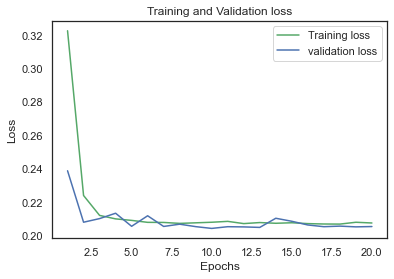

Evaluate on test data
670/670 [==============================] - 2s 2ms/step - loss: 0.2069
test loss, test acc: 0.20685818791389465


In [184]:
#3 neurons,0.6 sparsity
arch = kncp.wirings.Random(3, 1, sparsity_level=0.6)
rnn_cell = LTCCell(arch)


model_rand19 = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model_rand19.compile(
    optimizer=tf.keras.optimizers.Adam(0.008,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model_rand19.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model_rand19.evaluate(test_x, test_y, batch_size=18)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 51s 58ms/step - loss: 1.0002 - val_loss: 0.9996
Epoch 2/20
753/753 [==============================] - 43s 57ms/step - loss: 0.9995 - val_loss: 0.9997
Epoch 3/20
753/753 [==============================] - 43s 57ms/step - loss: 1.0016 - val_loss: 0.9998
Epoch 4/20
753/753 [==============================] - 47s 62ms/step - loss: 1.0003 - val_loss: 0.9995
Epoch 5/20
753/753 [==============================] - 405s 539ms/step - loss: 1.0053 - val_loss: 0.9996
Epoch 6/20
753/753 [==============================] - 48s 63ms/step - loss: 1.0034 - val_loss: 1.0006
Epoch 7/20
753/753 [==============================] - 45s 59ms/step - loss: 0.9986 - val_loss: 0.9996
Epoch 8/20
753/753 [==============================] - 44s 59ms/step - loss: 0.9979 - val_loss: 1.0004
Epoch 9/20
753/753 [==============================] - 45s 59ms/step - loss: 0.9996 - val_loss: 0.9996
Epoch 10/20
753/753 [==============================] - 48s 64ms/step - loss: 0.9

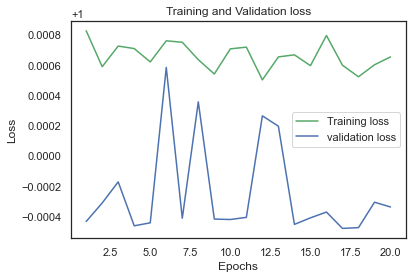

Evaluate on test data
670/670 [==============================] - 2s 2ms/step - loss: 1.0003
test loss, test acc: 1.0002760887145996


In [185]:
#3 neurons,0.8 sparsity
arch = kncp.wirings.Random(3, 1, sparsity_level=0.8)
rnn_cell = LTCCell(arch)


model_rand19 = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model_rand19.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model_rand19.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model_rand19.evaluate(test_x, test_y, batch_size=18)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 51s 58ms/step - loss: 1.0017 - val_loss: 1.0008
Epoch 2/20
753/753 [==============================] - 42s 56ms/step - loss: 0.9972 - val_loss: 1.0006
Epoch 3/20
753/753 [==============================] - 42s 56ms/step - loss: 1.0040 - val_loss: 0.9995
Epoch 4/20
753/753 [==============================] - 43s 57ms/step - loss: 0.9989 - val_loss: 0.9995
Epoch 5/20
753/753 [==============================] - 77s 103ms/step - loss: 1.0000 - val_loss: 0.9996
Epoch 6/20
753/753 [==============================] - 1549s 2s/step - loss: 1.0016 - val_loss: 1.0000
Epoch 7/20
753/753 [==============================] - 53s 70ms/step - loss: 1.0021 - val_loss: 1.0022
Epoch 8/20
753/753 [==============================] - 46s 61ms/step - loss: 0.9989 - val_loss: 1.0005
Epoch 9/20
753/753 [==============================] - 45s 59ms/step - loss: 1.0009 - val_loss: 1.0019
Epoch 10/20
753/753 [==============================] - 47s 62ms/step - loss: 0.99

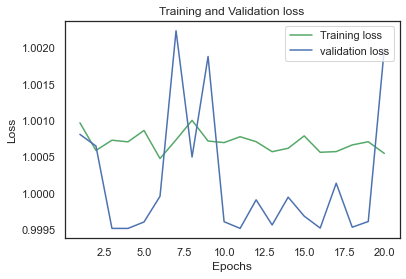

Evaluate on test data
670/670 [==============================] - 2s 2ms/step - loss: 1.0003
test loss, test acc: 1.0002760887145996


In [186]:
#3 neurons,0.8 sparsity
arch = kncp.wirings.Random(3, 1, sparsity_level=0.8)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model_rand19.evaluate(test_x, test_y, batch_size=18)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 62s 71ms/step - loss: 0.4518 - val_loss: 0.2127
Epoch 2/20
753/753 [==============================] - 46s 61ms/step - loss: 0.2137 - val_loss: 0.2091
Epoch 3/20
753/753 [==============================] - 51s 67ms/step - loss: 0.1974 - val_loss: 0.1916
Epoch 4/20
753/753 [==============================] - 45s 60ms/step - loss: 0.1891 - val_loss: 0.1918
Epoch 5/20
753/753 [==============================] - 45s 60ms/step - loss: 0.1848 - val_loss: 0.1872
Epoch 6/20
753/753 [==============================] - 43s 57ms/step - loss: 0.1838 - val_loss: 0.1898
Epoch 7/20
753/753 [==============================] - 43s 57ms/step - loss: 0.1844 - val_loss: 0.1868
Epoch 8/20
753/753 [==============================] - 44s 59ms/step - loss: 0.1848 - val_loss: 0.1863
Epoch 9/20
753/753 [==============================] - 45s 60ms/step - loss: 0.1843 - val_loss: 0.2018
Epoch 10/20
753/753 [==============================] - 47s 62ms/step - loss: 0.187

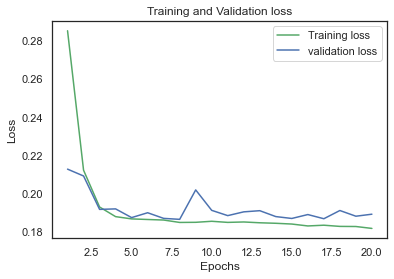

Evaluate on test data
670/670 [==============================] - 2s 2ms/step - loss: 0.1830
test loss, test acc: 0.18303270637989044


In [194]:
#6 neurons,0.3 sparsity
arch = kncp.wirings.Random(6, 1, sparsity_level=0.3)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=18)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 55s 59ms/step - loss: 0.4613 - val_loss: 0.2416
Epoch 2/20
753/753 [==============================] - 43s 58ms/step - loss: 0.2132 - val_loss: 0.2013
Epoch 3/20
753/753 [==============================] - 44s 58ms/step - loss: 0.1998 - val_loss: 0.2036
Epoch 4/20
753/753 [==============================] - 44s 58ms/step - loss: 0.2004 - val_loss: 0.2018
Epoch 5/20
753/753 [==============================] - 44s 58ms/step - loss: 0.2015 - val_loss: 0.2005
Epoch 6/20
753/753 [==============================] - 44s 58ms/step - loss: 0.1977 - val_loss: 0.1988
Epoch 7/20
753/753 [==============================] - 44s 58ms/step - loss: 0.1972 - val_loss: 0.1967
Epoch 8/20
753/753 [==============================] - 44s 58ms/step - loss: 0.1936 - val_loss: 0.1971
Epoch 9/20
753/753 [==============================] - 44s 58ms/step - loss: 0.1994 - val_loss: 0.1945
Epoch 10/20
753/753 [==============================] - 46s 61ms/step - loss: 0.197

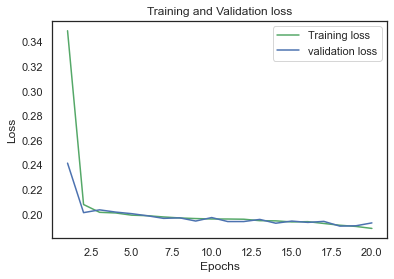

Evaluate on test data
670/670 [==============================] - 2s 2ms/step - loss: 0.1913
test loss, test acc: 0.1913347691297531


In [195]:
#6 neurons,0.6 sparsity
arch = kncp.wirings.Random(6, 1, sparsity_level=0.6)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=18)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 53s 60ms/step - loss: 0.9987 - val_loss: 0.9997
Epoch 2/20
753/753 [==============================] - 54s 71ms/step - loss: 0.9990 - val_loss: 0.9996
Epoch 3/20
753/753 [==============================] - 51s 68ms/step - loss: 1.0011 - val_loss: 0.9998
Epoch 4/20
753/753 [==============================] - 48s 64ms/step - loss: 1.0023 - val_loss: 0.9996
Epoch 5/20
753/753 [==============================] - 45s 60ms/step - loss: 1.0006 - val_loss: 0.9999
Epoch 6/20
753/753 [==============================] - 54s 72ms/step - loss: 0.9955 - val_loss: 1.0000
Epoch 7/20
753/753 [==============================] - 53s 71ms/step - loss: 1.0015 - val_loss: 0.9995
Epoch 8/20
753/753 [==============================] - 45s 60ms/step - loss: 0.9989 - val_loss: 0.9995
Epoch 9/20
753/753 [==============================] - 46s 61ms/step - loss: 1.0071 - val_loss: 0.9998
Epoch 10/20
753/753 [==============================] - 46s 61ms/step - loss: 0.998

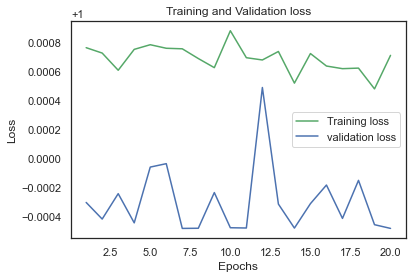

Evaluate on test data
670/670 [==============================] - 2s 2ms/step - loss: 1.0001
test loss, test acc: 1.0001215934753418


In [196]:
#6 neurons,0.8 sparsity
arch = kncp.wirings.Random(6, 1, sparsity_level=0.8)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=18)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 60s 68ms/step - loss: 0.4483 - val_loss: 0.2009
Epoch 2/20
753/753 [==============================] - 50s 66ms/step - loss: 0.1968 - val_loss: 0.1875
Epoch 3/20
753/753 [==============================] - 50s 67ms/step - loss: 0.1869 - val_loss: 0.1899
Epoch 4/20
753/753 [==============================] - 49s 65ms/step - loss: 0.1815 - val_loss: 0.1940
Epoch 5/20
753/753 [==============================] - 51s 67ms/step - loss: 0.1756 - val_loss: 0.1947
Epoch 6/20
753/753 [==============================] - 49s 65ms/step - loss: 0.1741 - val_loss: 0.1977
Epoch 7/20
753/753 [==============================] - 47s 63ms/step - loss: 0.1687 - val_loss: 0.1993
Epoch 8/20
753/753 [==============================] - 46s 60ms/step - loss: 0.1652 - val_loss: 0.2007
Epoch 9/20
753/753 [==============================] - 49s 66ms/step - loss: 0.1658 - val_loss: 0.1995
Epoch 10/20
753/753 [==============================] - 46s 61ms/step - loss: 0.160

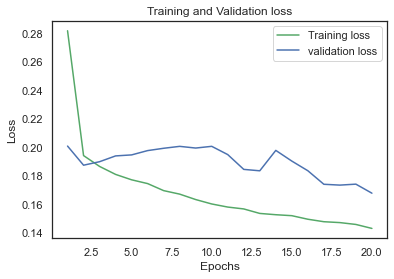

Evaluate on test data
670/670 [==============================] - 2s 2ms/step - loss: 0.1949
test loss, test acc: 0.19485639035701752


In [198]:
#8 neurons,0.3 sparsity
arch = kncp.wirings.Random(8, 1, sparsity_level=0.3)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=18)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 55s 58ms/step - loss: 1.0052 - val_loss: 1.0018
Epoch 2/20
753/753 [==============================] - 43s 58ms/step - loss: 0.9974 - val_loss: 1.0002
Epoch 3/20
753/753 [==============================] - 43s 58ms/step - loss: 1.0032 - val_loss: 0.9999
Epoch 4/20
753/753 [==============================] - 44s 58ms/step - loss: 1.0003 - val_loss: 0.9996
Epoch 5/20
753/753 [==============================] - 44s 58ms/step - loss: 1.0013 - val_loss: 0.9996
Epoch 6/20
753/753 [==============================] - 44s 59ms/step - loss: 1.0048 - val_loss: 0.9996
Epoch 7/20
753/753 [==============================] - 44s 58ms/step - loss: 1.0007 - val_loss: 1.0020
Epoch 8/20
753/753 [==============================] - 44s 58ms/step - loss: 1.0016 - val_loss: 1.0008
Epoch 9/20
753/753 [==============================] - 44s 58ms/step - loss: 0.9999 - val_loss: 0.9997
Epoch 10/20
753/753 [==============================] - 44s 58ms/step - loss: 1.001

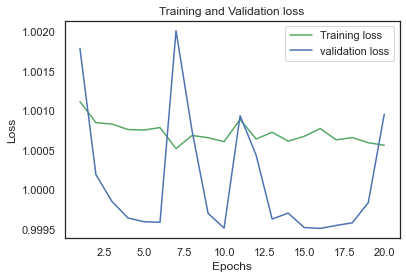

Evaluate on test data
670/670 [==============================] - 2s 2ms/step - loss: 1.0015
test loss, test acc: 1.0015472173690796


In [206]:
#8 neurons,0.8 sparsity
arch = kncp.wirings.Random(8, 1, sparsity_level=0.8)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=18)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 53s 60ms/step - loss: 0.4137 - val_loss: 0.1936
Epoch 2/20
753/753 [==============================] - 45s 59ms/step - loss: 0.1879 - val_loss: 0.1898
Epoch 3/20
753/753 [==============================] - 45s 59ms/step - loss: 0.1869 - val_loss: 0.1947
Epoch 4/20
753/753 [==============================] - 45s 60ms/step - loss: 0.1806 - val_loss: 0.1935
Epoch 5/20
753/753 [==============================] - 45s 60ms/step - loss: 0.1704 - val_loss: 0.1816
Epoch 6/20
753/753 [==============================] - 45s 60ms/step - loss: 0.1686 - val_loss: 0.1863
Epoch 7/20
753/753 [==============================] - 45s 59ms/step - loss: 0.1707 - val_loss: 0.1827
Epoch 8/20
753/753 [==============================] - 45s 59ms/step - loss: 0.1652 - val_loss: 0.1870
Epoch 9/20
753/753 [==============================] - 45s 59ms/step - loss: 0.1631 - val_loss: 0.1746
Epoch 10/20
753/753 [==============================] - 45s 59ms/step - loss: 0.161

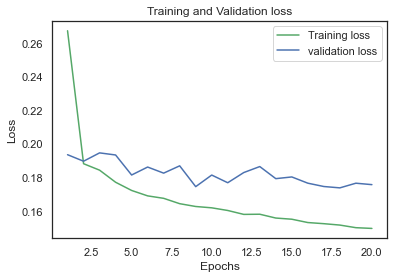

Evaluate on test data
670/670 [==============================] - 2s 2ms/step - loss: 0.1785
test loss, test acc: 0.17853450775146484


In [207]:
#10 neurons,0.3 sparsity
arch = kncp.wirings.Random(10, 1, sparsity_level=0.3)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=18)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 54s 62ms/step - loss: 0.3277 - val_loss: 0.2060
Epoch 2/20
753/753 [==============================] - 46s 60ms/step - loss: 0.2047 - val_loss: 0.2028
Epoch 3/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1935 - val_loss: 0.2041
Epoch 4/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1906 - val_loss: 0.2066
Epoch 5/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1879 - val_loss: 0.2072
Epoch 6/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1869 - val_loss: 0.1959
Epoch 7/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1990 - val_loss: 0.2027
Epoch 8/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1919 - val_loss: 0.1981
Epoch 9/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1845 - val_loss: 0.1979
Epoch 10/20
753/753 [==============================] - 46s 61ms/step - loss: 0.181

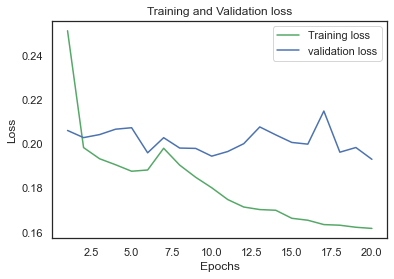

Evaluate on test data
670/670 [==============================] - 2s 2ms/step - loss: 0.1758
test loss, test acc: 0.17575611174106598


In [208]:
#10 neurons,0.6 sparsity
arch = kncp.wirings.Random(10, 1, sparsity_level=0.6)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=18)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 54s 62ms/step - loss: 0.7569 - val_loss: 0.3285
Epoch 2/20
753/753 [==============================] - 46s 61ms/step - loss: 0.3362 - val_loss: 0.3336
Epoch 3/20
753/753 [==============================] - 46s 61ms/step - loss: 0.3310 - val_loss: 0.3352
Epoch 4/20
753/753 [==============================] - 46s 61ms/step - loss: 0.3311 - val_loss: 0.3337
Epoch 5/20
753/753 [==============================] - 46s 61ms/step - loss: 0.3258 - val_loss: 0.3290
Epoch 6/20
753/753 [==============================] - 46s 61ms/step - loss: 0.3300 - val_loss: 0.3281
Epoch 7/20
753/753 [==============================] - 46s 61ms/step - loss: 0.3275 - val_loss: 0.3298
Epoch 8/20
753/753 [==============================] - 46s 61ms/step - loss: 0.3291 - val_loss: 0.3296
Epoch 9/20
753/753 [==============================] - 46s 61ms/step - loss: 0.3322 - val_loss: 0.3262
Epoch 10/20
753/753 [==============================] - 46s 62ms/step - loss: 0.327

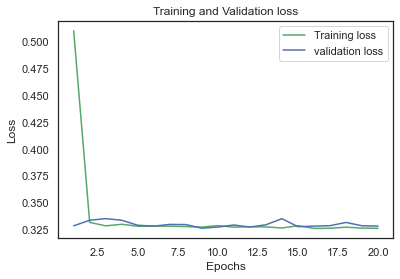

Evaluate on test data
670/670 [==============================] - 2s 2ms/step - loss: 0.3248
test loss, test acc: 0.32480165362358093


In [209]:
#10 neurons,0.8 sparsity
arch = kncp.wirings.Random(10, 1, sparsity_level=0.8)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=18)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 57s 62ms/step - loss: 0.3630 - val_loss: 0.1968
Epoch 2/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1836 - val_loss: 0.1923
Epoch 3/20
753/753 [==============================] - 46s 62ms/step - loss: 0.1786 - val_loss: 0.2082
Epoch 4/20
753/753 [==============================] - 46s 62ms/step - loss: 0.1646 - val_loss: 0.1898
Epoch 5/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1587 - val_loss: 0.1913
Epoch 6/20
753/753 [==============================] - 46s 62ms/step - loss: 0.1541 - val_loss: 0.1896
Epoch 7/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1511 - val_loss: 0.1877
Epoch 8/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1492 - val_loss: 0.1965
Epoch 9/20
753/753 [==============================] - 47s 62ms/step - loss: 0.1514 - val_loss: 0.1897
Epoch 10/20
753/753 [==============================] - 46s 61ms/step - loss: 0.148

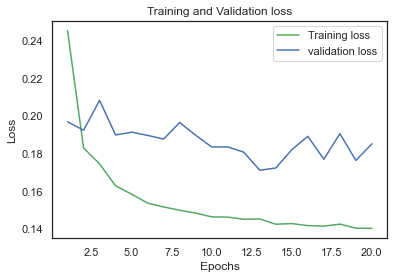

Evaluate on test data
670/670 [==============================] - 2s 3ms/step - loss: 0.1687
test loss, test acc: 0.16869480907917023


In [210]:
#12 neurons,0.3 sparsity
arch = kncp.wirings.Random(12, 1, sparsity_level=0.3)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=18)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 56s 65ms/step - loss: 0.4631 - val_loss: 0.2087
Epoch 2/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1939 - val_loss: 0.2137
Epoch 3/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1828 - val_loss: 0.2250
Epoch 4/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1763 - val_loss: 0.2088
Epoch 5/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1778 - val_loss: 0.1991
Epoch 6/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1705 - val_loss: 0.1945
Epoch 7/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1688 - val_loss: 0.1981
Epoch 8/20
753/753 [==============================] - 49s 65ms/step - loss: 0.1655 - val_loss: 0.1964
Epoch 9/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1668 - val_loss: 0.2080
Epoch 10/20
753/753 [==============================] - 48s 64ms/step - loss: 0.164

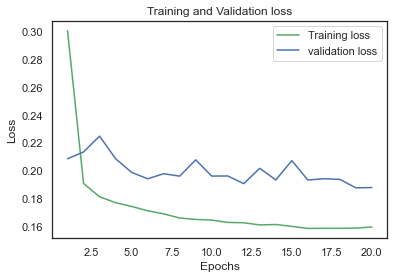

Evaluate on test data
670/670 [==============================] - 2s 2ms/step - loss: 0.1725
test loss, test acc: 0.17252199351787567


In [211]:
#12 neurons,0.6 sparsity
arch = kncp.wirings.Random(12, 1, sparsity_level=0.6)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=18)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 53s 62ms/step - loss: 0.4680 - val_loss: 0.3331
Epoch 2/20
753/753 [==============================] - 46s 61ms/step - loss: 0.3365 - val_loss: 0.3312
Epoch 3/20
753/753 [==============================] - 46s 61ms/step - loss: 0.3299 - val_loss: 0.3302
Epoch 4/20
753/753 [==============================] - 46s 61ms/step - loss: 0.3328 - val_loss: 0.3328
Epoch 5/20
753/753 [==============================] - 46s 61ms/step - loss: 0.3294 - val_loss: 0.3289
Epoch 6/20
753/753 [==============================] - 46s 61ms/step - loss: 0.3290 - val_loss: 0.3245
Epoch 7/20
753/753 [==============================] - 46s 61ms/step - loss: 0.3239 - val_loss: 0.3243
Epoch 8/20
753/753 [==============================] - 46s 61ms/step - loss: 0.3235 - val_loss: 0.3254
Epoch 9/20
753/753 [==============================] - 46s 61ms/step - loss: 0.3267 - val_loss: 0.3305
Epoch 10/20
753/753 [==============================] - 46s 61ms/step - loss: 0.320

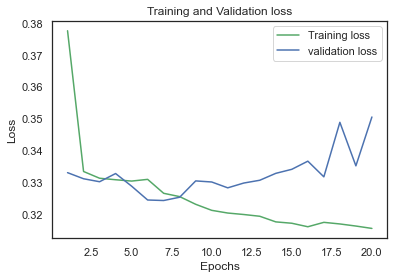

Evaluate on test data
670/670 [==============================] - 2s 2ms/step - loss: 0.3400
test loss, test acc: 0.3400213420391083


In [212]:
#12 neurons,0.8 sparsity
arch = kncp.wirings.Random(12, 1, sparsity_level=0.8)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=18)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 51s 58ms/step - loss: 0.4103 - val_loss: 0.2350
Epoch 2/20
753/753 [==============================] - 44s 58ms/step - loss: 0.2220 - val_loss: 0.2158
Epoch 3/20
753/753 [==============================] - 49s 65ms/step - loss: 0.2098 - val_loss: 0.2216
Epoch 4/20
753/753 [==============================] - 50s 67ms/step - loss: 0.2044 - val_loss: 0.2018
Epoch 5/20
753/753 [==============================] - 52s 69ms/step - loss: 0.1826 - val_loss: 0.2082
Epoch 6/20
753/753 [==============================] - 45s 59ms/step - loss: 0.1786 - val_loss: 0.2048
Epoch 7/20
753/753 [==============================] - 49s 65ms/step - loss: 0.1769 - val_loss: 0.2321
Epoch 8/20
753/753 [==============================] - 53s 70ms/step - loss: 0.1742 - val_loss: 0.1922
Epoch 9/20
753/753 [==============================] - 53s 70ms/step - loss: 0.1759 - val_loss: 0.1840
Epoch 10/20
753/753 [==============================] - 44s 59ms/step - loss: 0.174

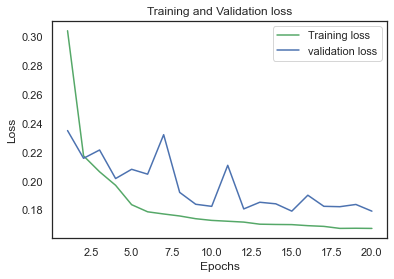

Evaluate on test data
753/753 [==============================] - 2s 2ms/step - loss: 0.1840
test loss, test acc: 0.18395768105983734


In [201]:
#6 neurons,0.6 sparsity
arch = kncp.wirings.Random(6, 1, sparsity_level=0.2)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=16)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 64s 73ms/step - loss: 0.9935 - val_loss: 0.9549
Epoch 2/20
753/753 [==============================] - 48s 63ms/step - loss: 0.8937 - val_loss: 0.2338
Epoch 3/20
753/753 [==============================] - 48s 63ms/step - loss: 0.2284 - val_loss: 0.2206
Epoch 4/20
753/753 [==============================] - 48s 64ms/step - loss: 0.2199 - val_loss: 0.2193
Epoch 5/20
753/753 [==============================] - 48s 64ms/step - loss: 0.2193 - val_loss: 0.2218
Epoch 6/20
753/753 [==============================] - 48s 64ms/step - loss: 0.2188 - val_loss: 0.2049
Epoch 7/20
753/753 [==============================] - 48s 64ms/step - loss: 0.2014 - val_loss: 0.2000
Epoch 8/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1958 - val_loss: 0.1995
Epoch 9/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1989 - val_loss: 0.1971
Epoch 10/20
753/753 [==============================] - 48s 64ms/step - loss: 0.196

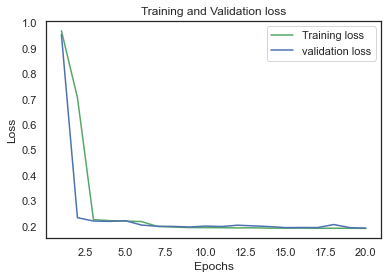

Evaluate on test data
753/753 [==============================] - 2s 2ms/step - loss: 0.1902
test loss, test acc: 0.1902320683002472


In [202]:
#3 neurons,0.2 sparsity
arch = kncp.wirings.Random(3, 1, sparsity_level=0.2)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=16)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 59s 68ms/step - loss: 0.4572 - val_loss: 0.2140
Epoch 2/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1956 - val_loss: 0.1967
Epoch 3/20
753/753 [==============================] - 44s 59ms/step - loss: 0.1691 - val_loss: 0.1939
Epoch 4/20
753/753 [==============================] - 44s 59ms/step - loss: 0.1651 - val_loss: 0.1878
Epoch 5/20
753/753 [==============================] - 47s 63ms/step - loss: 0.1633 - val_loss: 0.1925
Epoch 6/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1596 - val_loss: 0.1875
Epoch 7/20
753/753 [==============================] - 45s 60ms/step - loss: 0.1579 - val_loss: 0.1862
Epoch 8/20
753/753 [==============================] - 45s 60ms/step - loss: 0.1567 - val_loss: 0.1822
Epoch 9/20
753/753 [==============================] - 45s 60ms/step - loss: 0.1574 - val_loss: 0.1839
Epoch 10/20
753/753 [==============================] - 49s 65ms/step - loss: 0.157

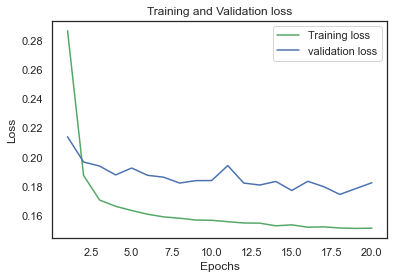

Evaluate on test data
753/753 [==============================] - 2s 2ms/step - loss: 0.1889
test loss, test acc: 0.18886367976665497


In [203]:
#8 neurons,0.6 sparsity
arch = kncp.wirings.Random(8, 1, sparsity_level=0.2)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=16)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 52s 59ms/step - loss: 0.4240 - val_loss: 0.1908
Epoch 2/20
753/753 [==============================] - 44s 58ms/step - loss: 0.1879 - val_loss: 0.1865
Epoch 3/20
753/753 [==============================] - 44s 58ms/step - loss: 0.1774 - val_loss: 0.1872
Epoch 4/20
753/753 [==============================] - 44s 59ms/step - loss: 0.1714 - val_loss: 0.1914
Epoch 5/20
753/753 [==============================] - 44s 59ms/step - loss: 0.1679 - val_loss: 0.2055
Epoch 6/20
753/753 [==============================] - 44s 59ms/step - loss: 0.1645 - val_loss: 0.1956
Epoch 7/20
753/753 [==============================] - 44s 59ms/step - loss: 0.1637 - val_loss: 0.1916
Epoch 8/20
753/753 [==============================] - 44s 58ms/step - loss: 0.1604 - val_loss: 0.1870
Epoch 9/20
753/753 [==============================] - 44s 58ms/step - loss: 0.1544 - val_loss: 0.1895
Epoch 10/20
753/753 [==============================] - 44s 58ms/step - loss: 0.154

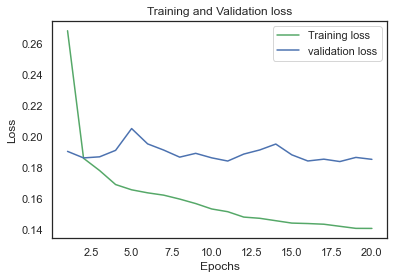

Evaluate on test data
753/753 [==============================] - 2s 2ms/step - loss: 0.1847
test loss, test acc: 0.184719055891037


In [204]:
#10 neurons,0.6 sparsity
arch = kncp.wirings.Random(10, 1, sparsity_level=0.2)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=16)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 53s 61ms/step - loss: 0.3450 - val_loss: 0.2074
Epoch 2/20
753/753 [==============================] - 45s 59ms/step - loss: 0.1901 - val_loss: 0.2000
Epoch 3/20
753/753 [==============================] - 44s 59ms/step - loss: 0.1843 - val_loss: 0.1880
Epoch 4/20
753/753 [==============================] - 45s 59ms/step - loss: 0.1812 - val_loss: 0.1862
Epoch 5/20
753/753 [==============================] - 44s 59ms/step - loss: 0.1804 - val_loss: 0.1923
Epoch 6/20
753/753 [==============================] - 44s 59ms/step - loss: 0.1806 - val_loss: 0.1871
Epoch 7/20
753/753 [==============================] - 44s 59ms/step - loss: 0.1759 - val_loss: 0.1856
Epoch 8/20
753/753 [==============================] - 44s 59ms/step - loss: 0.1755 - val_loss: 0.1878
Epoch 9/20
753/753 [==============================] - 44s 59ms/step - loss: 0.1739 - val_loss: 0.1837
Epoch 10/20
753/753 [==============================] - 44s 59ms/step - loss: 0.173

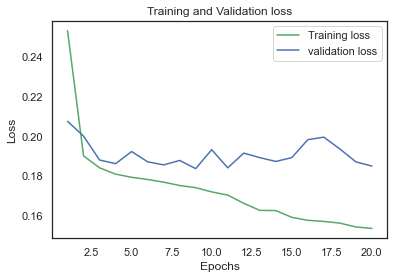

Evaluate on test data
753/753 [==============================] - 2s 2ms/step - loss: 0.1669
test loss, test acc: 0.16685281693935394


In [205]:
#12 neurons,0.6 sparsity
arch = kncp.wirings.Random(12, 1, sparsity_level=0.2)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=16)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 66s 70ms/step - loss: 0.4474 - val_loss: 0.2134
Epoch 2/20
753/753 [==============================] - 52s 70ms/step - loss: 0.1892 - val_loss: 0.1986
Epoch 3/20
753/753 [==============================] - 52s 70ms/step - loss: 0.1790 - val_loss: 0.1914
Epoch 4/20
753/753 [==============================] - 55s 74ms/step - loss: 0.1719 - val_loss: 0.1963
Epoch 5/20
753/753 [==============================] - 59s 78ms/step - loss: 0.1700 - val_loss: 0.1943
Epoch 6/20
753/753 [==============================] - 58s 78ms/step - loss: 0.1598 - val_loss: 0.1872
Epoch 7/20
753/753 [==============================] - 68s 90ms/step - loss: 0.1562 - val_loss: 0.1957
Epoch 8/20
753/753 [==============================] - 60s 80ms/step - loss: 0.1542 - val_loss: 0.1934
Epoch 9/20
753/753 [==============================] - 75s 99ms/step - loss: 0.1514 - val_loss: 0.1881
Epoch 10/20
753/753 [==============================] - 49s 65ms/step - loss: 0.148

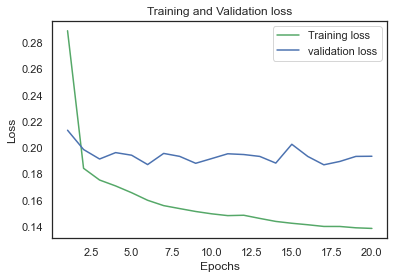

Evaluate on test data
753/753 [==============================] - 3s 3ms/step - loss: 0.1638
test loss, test acc: 0.16383354365825653


In [213]:
#14 neurons,0.2 sparsity
arch = kncp.wirings.Random(14, 1, sparsity_level=0.2)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=16)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 55s 63ms/step - loss: 0.4215 - val_loss: 0.1985
Epoch 2/20
753/753 [==============================] - 47s 63ms/step - loss: 0.1805 - val_loss: 0.2029
Epoch 3/20
753/753 [==============================] - 47s 62ms/step - loss: 0.1727 - val_loss: 0.1915
Epoch 4/20
753/753 [==============================] - 47s 62ms/step - loss: 0.1643 - val_loss: 0.2017
Epoch 5/20
753/753 [==============================] - 47s 62ms/step - loss: 0.1604 - val_loss: 0.1937
Epoch 6/20
753/753 [==============================] - 47s 63ms/step - loss: 0.1577 - val_loss: 0.1908
Epoch 7/20
753/753 [==============================] - 47s 62ms/step - loss: 0.1556 - val_loss: 0.1895
Epoch 8/20
753/753 [==============================] - 47s 62ms/step - loss: 0.1517 - val_loss: 0.1859
Epoch 9/20
753/753 [==============================] - 47s 63ms/step - loss: 0.1495 - val_loss: 0.1924
Epoch 10/20
753/753 [==============================] - 47s 62ms/step - loss: 0.149

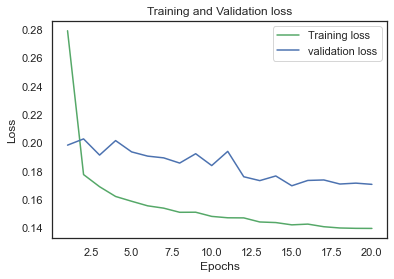

Evaluate on test data
753/753 [==============================] - 2s 2ms/step - loss: 0.1804
test loss, test acc: 0.1803964078426361


In [214]:
#14 neurons,0.3 sparsity
arch = kncp.wirings.Random(14, 1, sparsity_level=0.3)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=16)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 54s 62ms/step - loss: 0.3242 - val_loss: 0.2023
Epoch 2/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1988 - val_loss: 0.1991
Epoch 3/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1913 - val_loss: 0.2093
Epoch 4/20
753/753 [==============================] - 46s 62ms/step - loss: 0.1935 - val_loss: 0.1986
Epoch 5/20
753/753 [==============================] - 47s 62ms/step - loss: 0.1944 - val_loss: 0.2030
Epoch 6/20
753/753 [==============================] - 46s 62ms/step - loss: 0.1933 - val_loss: 0.1990
Epoch 7/20
753/753 [==============================] - 46s 62ms/step - loss: 0.1970 - val_loss: 0.1977
Epoch 8/20
753/753 [==============================] - 47s 62ms/step - loss: 0.1942 - val_loss: 0.1985
Epoch 9/20
753/753 [==============================] - 46s 62ms/step - loss: 0.1936 - val_loss: 0.1998
Epoch 10/20
753/753 [==============================] - 47s 62ms/step - loss: 0.192

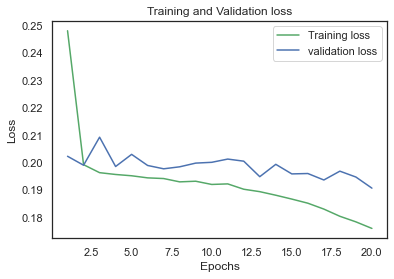

Evaluate on test data
753/753 [==============================] - 2s 2ms/step - loss: 0.1921
test loss, test acc: 0.19207985699176788


In [215]:
#14 neurons,0.6 sparsity
arch = kncp.wirings.Random(14, 1, sparsity_level=0.6)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=16)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 57s 61ms/step - loss: 0.9945 - val_loss: 0.9483
Epoch 2/20
753/753 [==============================] - 47s 63ms/step - loss: 0.9552 - val_loss: 0.9489
Epoch 3/20
753/753 [==============================] - 48s 64ms/step - loss: 0.9516 - val_loss: 0.9533
Epoch 4/20
753/753 [==============================] - 47s 62ms/step - loss: 0.9444 - val_loss: 0.9533
Epoch 5/20
753/753 [==============================] - 48s 64ms/step - loss: 0.9499 - val_loss: 0.9476
Epoch 6/20
753/753 [==============================] - 48s 64ms/step - loss: 0.9515 - val_loss: 0.9484
Epoch 7/20
753/753 [==============================] - 48s 64ms/step - loss: 0.9474 - val_loss: 0.9495
Epoch 8/20
753/753 [==============================] - 48s 64ms/step - loss: 0.9487 - val_loss: 0.9459
Epoch 9/20
753/753 [==============================] - 49s 65ms/step - loss: 0.9450 - val_loss: 0.9440
Epoch 10/20
753/753 [==============================] - 48s 64ms/step - loss: 0.938

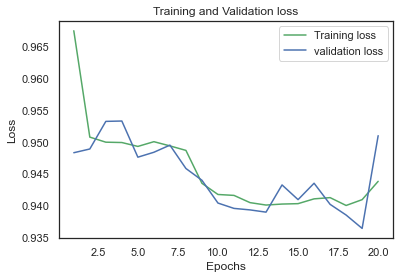

Evaluate on test data
753/753 [==============================] - 2s 2ms/step - loss: 0.9531
test loss, test acc: 0.9531052708625793


In [217]:
#14 neurons,0.8 sparsity
arch = kncp.wirings.Random(14, 1, sparsity_level=0.8)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=16)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 55s 64ms/step - loss: 0.3985 - val_loss: 0.1935
Epoch 2/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1792 - val_loss: 0.1892
Epoch 3/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1651 - val_loss: 0.1896
Epoch 4/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1566 - val_loss: 0.1803
Epoch 5/20
753/753 [==============================] - 49s 64ms/step - loss: 0.1471 - val_loss: 0.1850
Epoch 6/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1405 - val_loss: 0.1821
Epoch 7/20
753/753 [==============================] - 49s 65ms/step - loss: 0.1404 - val_loss: 0.1907
Epoch 8/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1358 - val_loss: 0.1789
Epoch 9/20
753/753 [==============================] - 48s 63ms/step - loss: 0.1361 - val_loss: 0.1825
Epoch 10/20
753/753 [==============================] - 48s 64ms/step - loss: 0.132

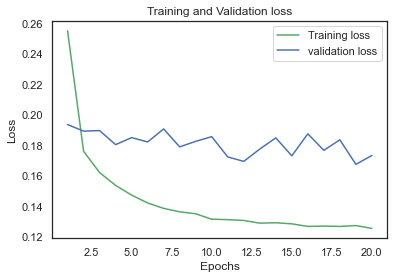

Evaluate on test data
753/753 [==============================] - 2s 2ms/step - loss: 0.1665
test loss, test acc: 0.16645605862140656


In [218]:
#16 neurons,0.2 sparsity
arch = kncp.wirings.Random(16, 1, sparsity_level=0.2)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=16)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 56s 64ms/step - loss: 0.3772 - val_loss: 0.1914
Epoch 2/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1819 - val_loss: 0.1949
Epoch 3/20
753/753 [==============================] - 49s 65ms/step - loss: 0.1592 - val_loss: 0.2039
Epoch 4/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1586 - val_loss: 0.2127
Epoch 5/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1497 - val_loss: 0.1986
Epoch 6/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1501 - val_loss: 0.2135
Epoch 7/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1429 - val_loss: 0.1993
Epoch 8/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1408 - val_loss: 0.1902
Epoch 9/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1382 - val_loss: 0.1746
Epoch 10/20
753/753 [==============================] - 49s 65ms/step - loss: 0.139

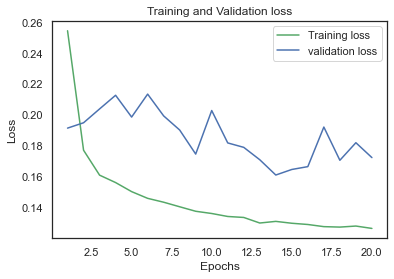

Evaluate on test data
753/753 [==============================] - 2s 2ms/step - loss: 0.1781
test loss, test acc: 0.17811287939548492


In [219]:
#16 neurons,0.3 sparsity
arch = kncp.wirings.Random(16, 1, sparsity_level=0.3)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=16)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 55s 63ms/step - loss: 0.3653 - val_loss: 0.2315
Epoch 2/20
753/753 [==============================] - 48s 64ms/step - loss: 0.2122 - val_loss: 0.2215
Epoch 3/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1926 - val_loss: 0.2183
Epoch 4/20
753/753 [==============================] - 49s 65ms/step - loss: 0.1848 - val_loss: 0.2275
Epoch 5/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1797 - val_loss: 0.2184
Epoch 6/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1739 - val_loss: 0.2202
Epoch 7/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1695 - val_loss: 0.2322
Epoch 8/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1662 - val_loss: 0.2177
Epoch 9/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1680 - val_loss: 0.2103
Epoch 10/20
753/753 [==============================] - 48s 64ms/step - loss: 0.164

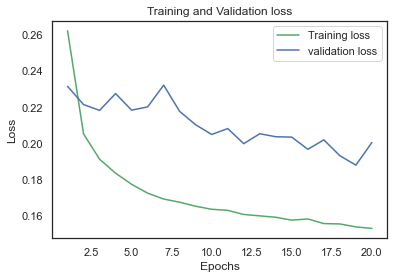

Evaluate on test data
753/753 [==============================] - 2s 2ms/step - loss: 0.2082
test loss, test acc: 0.20824408531188965


In [220]:
#16 neurons,0.6 sparsity
arch = kncp.wirings.Random(16, 1, sparsity_level=0.6)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=16)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 55s 64ms/step - loss: 0.9909 - val_loss: 0.9844
Epoch 2/20
753/753 [==============================] - 48s 64ms/step - loss: 0.9848 - val_loss: 0.8692
Epoch 3/20
753/753 [==============================] - 48s 64ms/step - loss: 0.4368 - val_loss: 0.3576
Epoch 4/20
753/753 [==============================] - 49s 65ms/step - loss: 0.3537 - val_loss: 0.3488
Epoch 5/20
753/753 [==============================] - 48s 64ms/step - loss: 0.3334 - val_loss: 0.2347
Epoch 6/20
753/753 [==============================] - 48s 64ms/step - loss: 0.2262 - val_loss: 0.2206
Epoch 7/20
753/753 [==============================] - 48s 64ms/step - loss: 0.2205 - val_loss: 0.2237
Epoch 8/20
753/753 [==============================] - 48s 64ms/step - loss: 0.2120 - val_loss: 0.2151
Epoch 9/20
753/753 [==============================] - 49s 65ms/step - loss: 0.2082 - val_loss: 0.2212
Epoch 10/20
753/753 [==============================] - 48s 64ms/step - loss: 0.208

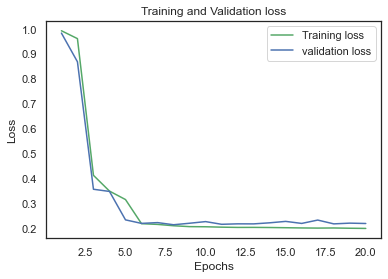

Evaluate on test data
753/753 [==============================] - 2s 2ms/step - loss: 0.2199
test loss, test acc: 0.21994562447071075


In [221]:
#16 neurons,0.8 sparsity
arch = kncp.wirings.Random(16, 1, sparsity_level=0.8)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=16)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 55s 64ms/step - loss: 0.7699 - val_loss: 0.2285
Epoch 2/20
753/753 [==============================] - 48s 64ms/step - loss: 0.2320 - val_loss: 0.2243
Epoch 3/20
753/753 [==============================] - 48s 64ms/step - loss: 0.2152 - val_loss: 0.2084
Epoch 4/20
753/753 [==============================] - 48s 64ms/step - loss: 0.2021 - val_loss: 0.2022
Epoch 5/20
753/753 [==============================] - 48s 64ms/step - loss: 0.2017 - val_loss: 0.2006
Epoch 6/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1923 - val_loss: 0.1958
Epoch 7/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1963 - val_loss: 0.1999
Epoch 8/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1933 - val_loss: 0.1976
Epoch 9/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1897 - val_loss: 0.1949
Epoch 10/20
753/753 [==============================] - 48s 64ms/step - loss: 0.187

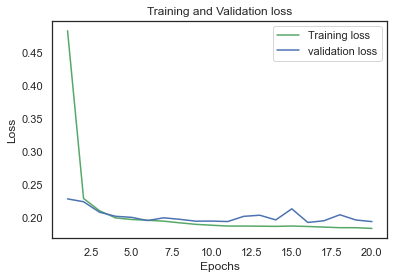

Evaluate on test data
753/753 [==============================] - 2s 2ms/step - loss: 0.1860
test loss, test acc: 0.18600305914878845


In [222]:
#16 neurons,0.8 sparsity
arch = kncp.wirings.Random(16, 1, sparsity_level=0.8)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=16)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 51s 59ms/step - loss: 0.4687 - val_loss: 0.2236
Epoch 2/20
753/753 [==============================] - 43s 57ms/step - loss: 0.2056 - val_loss: 0.1986
Epoch 3/20
753/753 [==============================] - 43s 57ms/step - loss: 0.1972 - val_loss: 0.2109
Epoch 4/20
753/753 [==============================] - 43s 58ms/step - loss: 0.1972 - val_loss: 0.2006
Epoch 5/20
753/753 [==============================] - 43s 58ms/step - loss: 0.1943 - val_loss: 0.1948
Epoch 6/20
753/753 [==============================] - 44s 59ms/step - loss: 0.1913 - val_loss: 0.1949
Epoch 7/20
753/753 [==============================] - 44s 58ms/step - loss: 0.1916 - val_loss: 0.2052
Epoch 8/20
753/753 [==============================] - 43s 58ms/step - loss: 0.1933 - val_loss: 0.1983
Epoch 9/20
753/753 [==============================] - 43s 58ms/step - loss: 0.1901 - val_loss: 0.1985
Epoch 10/20
753/753 [==============================] - 43s 57ms/step - loss: 0.189

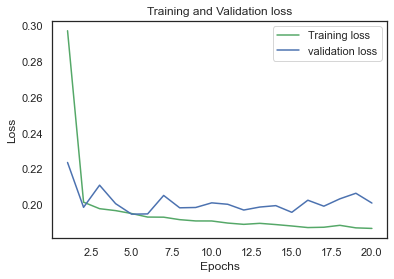

Evaluate on test data
753/753 [==============================] - 2s 2ms/step - loss: 0.1885
test loss, test acc: 0.18849758803844452


In [223]:
#3 neurons,0.1 sparsity
arch = kncp.wirings.Random(3, 1, sparsity_level=0.1)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=16)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 55s 61ms/step - loss: 0.5006 - val_loss: 0.2071
Epoch 2/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1980 - val_loss: 0.1922
Epoch 3/20
753/753 [==============================] - 47s 62ms/step - loss: 0.1859 - val_loss: 0.1881
Epoch 4/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1812 - val_loss: 0.2040
Epoch 5/20
753/753 [==============================] - 46s 62ms/step - loss: 0.1804 - val_loss: 0.1907
Epoch 6/20
753/753 [==============================] - 47s 62ms/step - loss: 0.1808 - val_loss: 0.1914
Epoch 7/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1769 - val_loss: 0.1929
Epoch 8/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1722 - val_loss: 0.1966
Epoch 9/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1731 - val_loss: 0.1996
Epoch 10/20
753/753 [==============================] - 46s 62ms/step - loss: 0.168

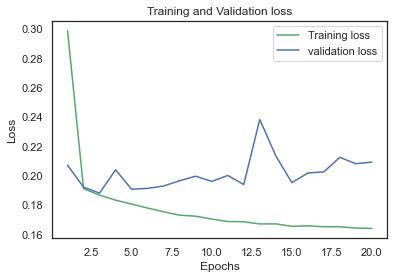

Evaluate on test data
753/753 [==============================] - 2s 2ms/step - loss: 0.1911
test loss, test acc: 0.19110123813152313


In [224]:
#6 neurons,0.1 sparsity
arch = kncp.wirings.Random(6, 1, sparsity_level=0.1)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=16)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 53s 61ms/step - loss: 0.4301 - val_loss: 0.1965
Epoch 2/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1947 - val_loss: 0.1964
Epoch 3/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1863 - val_loss: 0.1924
Epoch 4/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1888 - val_loss: 0.1893
Epoch 5/20
753/753 [==============================] - 45s 60ms/step - loss: 0.1840 - val_loss: 0.2042
Epoch 6/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1795 - val_loss: 0.1960
Epoch 7/20
753/753 [==============================] - 45s 60ms/step - loss: 0.1775 - val_loss: 0.1898
Epoch 8/20
753/753 [==============================] - 45s 60ms/step - loss: 0.1748 - val_loss: 0.1907
Epoch 9/20
753/753 [==============================] - 45s 60ms/step - loss: 0.1897 - val_loss: 0.1983
Epoch 10/20
753/753 [==============================] - 46s 61ms/step - loss: 0.182

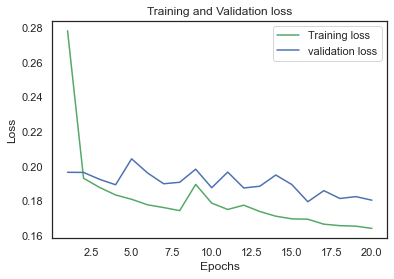

Evaluate on test data
753/753 [==============================] - 2s 2ms/step - loss: 0.1770
test loss, test acc: 0.17697125673294067


In [225]:
#8 neurons,0.1 sparsity
arch = kncp.wirings.Random(8, 1, sparsity_level=0.1)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=16)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 52s 60ms/step - loss: 0.3971 - val_loss: 0.2045
Epoch 2/20
753/753 [==============================] - 45s 60ms/step - loss: 0.1924 - val_loss: 0.2086
Epoch 3/20
753/753 [==============================] - 46s 62ms/step - loss: 0.1881 - val_loss: 0.1990
Epoch 4/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1827 - val_loss: 0.1974
Epoch 5/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1832 - val_loss: 0.1964
Epoch 6/20
753/753 [==============================] - 44s 59ms/step - loss: 0.1791 - val_loss: 0.1956
Epoch 7/20
753/753 [==============================] - 44s 59ms/step - loss: 0.1786 - val_loss: 0.1955
Epoch 8/20
753/753 [==============================] - 44s 59ms/step - loss: 0.1757 - val_loss: 0.1995
Epoch 9/20
753/753 [==============================] - 45s 59ms/step - loss: 0.1757 - val_loss: 0.1964
Epoch 10/20
753/753 [==============================] - 44s 59ms/step - loss: 0.175

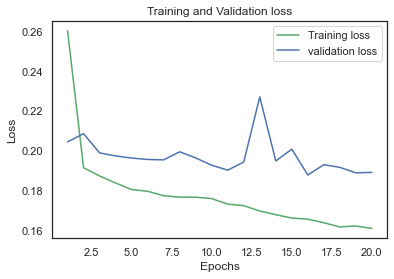

Evaluate on test data
753/753 [==============================] - 2s 2ms/step - loss: 0.1780
test loss, test acc: 0.17799079418182373


In [226]:
#8 neurons,0.1 sparsity
arch = kncp.wirings.Random(8, 1, sparsity_level=0.1)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=16)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 53s 61ms/step - loss: 0.3641 - val_loss: 0.1913
Epoch 2/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1909 - val_loss: 0.1929
Epoch 3/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1773 - val_loss: 0.1947
Epoch 4/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1711 - val_loss: 0.1976
Epoch 5/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1665 - val_loss: 0.2127
Epoch 6/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1637 - val_loss: 0.2001
Epoch 7/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1575 - val_loss: 0.1969
Epoch 8/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1602 - val_loss: 0.1944
Epoch 9/20
753/753 [==============================] - 46s 61ms/step - loss: 0.1531 - val_loss: 0.1957
Epoch 10/20
753/753 [==============================] - 46s 61ms/step - loss: 0.154

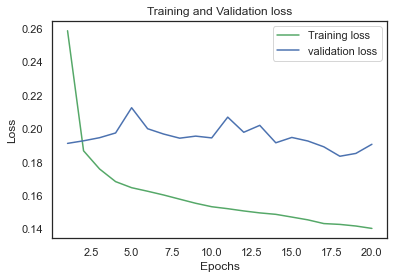

Evaluate on test data
753/753 [==============================] - 2s 2ms/step - loss: 0.1795
test loss, test acc: 0.17952468991279602


In [227]:
#10 neurons,0.1 sparsity
arch = kncp.wirings.Random(10, 1, sparsity_level=0.1)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=16)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 58s 62ms/step - loss: 0.3964 - val_loss: 0.1918
Epoch 2/20
753/753 [==============================] - 47s 63ms/step - loss: 0.1852 - val_loss: 0.2038
Epoch 3/20
753/753 [==============================] - 47s 62ms/step - loss: 0.1735 - val_loss: 0.2011
Epoch 4/20
753/753 [==============================] - 47s 62ms/step - loss: 0.1660 - val_loss: 0.2097
Epoch 5/20
753/753 [==============================] - 47s 62ms/step - loss: 0.1587 - val_loss: 0.1879
Epoch 6/20
753/753 [==============================] - 47s 62ms/step - loss: 0.1548 - val_loss: 0.1815
Epoch 7/20
753/753 [==============================] - 47s 62ms/step - loss: 0.1588 - val_loss: 0.1842
Epoch 8/20
753/753 [==============================] - 47s 63ms/step - loss: 0.1518 - val_loss: 0.1837
Epoch 9/20
753/753 [==============================] - 47s 63ms/step - loss: 0.1480 - val_loss: 0.1809
Epoch 10/20
753/753 [==============================] - 47s 62ms/step - loss: 0.144

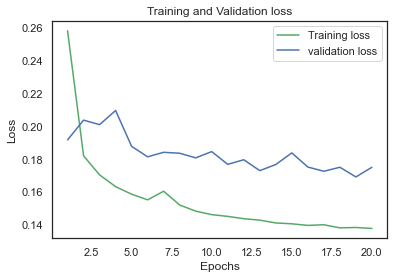

Evaluate on test data
753/753 [==============================] - 2s 2ms/step - loss: 0.1705
test loss, test acc: 0.17052336037158966


In [228]:
#12 neurons,0.1 sparsity
arch = kncp.wirings.Random(12, 1, sparsity_level=0.1)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=16)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 57s 66ms/step - loss: 0.3344 - val_loss: 0.1916
Epoch 2/20
753/753 [==============================] - 49s 65ms/step - loss: 0.1820 - val_loss: 0.1977
Epoch 3/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1736 - val_loss: 0.1873
Epoch 4/20
753/753 [==============================] - 49s 65ms/step - loss: 0.1639 - val_loss: 0.1858
Epoch 5/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1569 - val_loss: 0.1910
Epoch 6/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1482 - val_loss: 0.2120
Epoch 7/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1421 - val_loss: 0.1995
Epoch 8/20
753/753 [==============================] - 48s 64ms/step - loss: 0.1402 - val_loss: 0.1958
Epoch 9/20
753/753 [==============================] - 49s 65ms/step - loss: 0.1361 - val_loss: 0.2007
Epoch 10/20
753/753 [==============================] - 51s 67ms/step - loss: 0.134

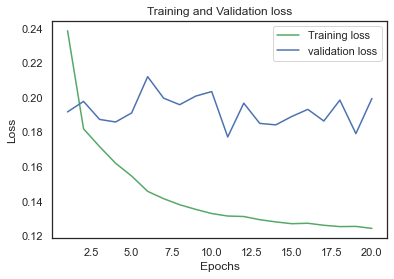

Evaluate on test data
753/753 [==============================] - 2s 2ms/step - loss: 0.1822
test loss, test acc: 0.18220585584640503


In [229]:
#14 neurons,0.1 sparsity
arch = kncp.wirings.Random(14, 1, sparsity_level=0.1)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=16)
print("test loss, test acc:", results)

Epoch 1/20
753/753 [==============================] - 63s 66ms/step - loss: 0.3698 - val_loss: 0.1956
Epoch 2/20
753/753 [==============================] - 49s 66ms/step - loss: 0.1851 - val_loss: 0.1902
Epoch 3/20
753/753 [==============================] - 50s 66ms/step - loss: 0.1665 - val_loss: 0.2024
Epoch 4/20
753/753 [==============================] - 69s 91ms/step - loss: 0.1541 - val_loss: 0.1962
Epoch 5/20
753/753 [==============================] - 68s 90ms/step - loss: 0.1458 - val_loss: 0.1882
Epoch 6/20
753/753 [==============================] - 52s 70ms/step - loss: 0.1373 - val_loss: 0.1840
Epoch 7/20
753/753 [==============================] - 56s 75ms/step - loss: 0.1339 - val_loss: 0.1880
Epoch 8/20
753/753 [==============================] - 63s 83ms/step - loss: 0.1329 - val_loss: 0.1784
Epoch 9/20
753/753 [==============================] - 60s 79ms/step - loss: 0.1301 - val_loss: 0.1942
Epoch 10/20
753/753 [==============================] - 55s 73ms/step - loss: 0.128

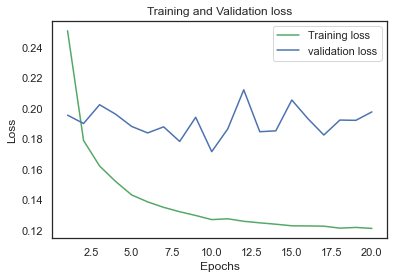

Evaluate on test data
753/753 [==============================] - 7s 5ms/step - loss: 0.1872
test loss, test acc: 0.18720440566539764


In [231]:
#16 neurons,0.1 sparsity
arch = kncp.wirings.Random(16, 1, sparsity_level=0.1)
rnn_cell = LTCCell(arch)


model = tf.keras.models.Sequential(
    [
        tf.keras.Input((None, 7)),
        tf.keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
)

traffic_ncp_history = model.fit(x=data_x, y=data_y, batch_size=16, epochs=20, validation_data=(valid_x,valid_y))
loss_train = traffic_ncp_history.history['loss']
loss_val = traffic_ncp_history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=16)
print("test loss, test acc:", results)